# Tall stick 2 team
### Team members:

+ Mike ke Passo
+ Alex
+ Pere
+ Albert
+ Jordi

# Prev. Analysis
Code from: https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [64]:
import numpy as np 
import pandas as pd 
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import chi2
%matplotlib inline

# pip install num2words
from num2words import num2words

import nltk
from nltk.stem import WordNetLemmatizer
# python -m nltk.downloader all

In [31]:
df_train = pd.read_csv('input/train.csv')
df_train.head()
df_test = pd.read_csv('input/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



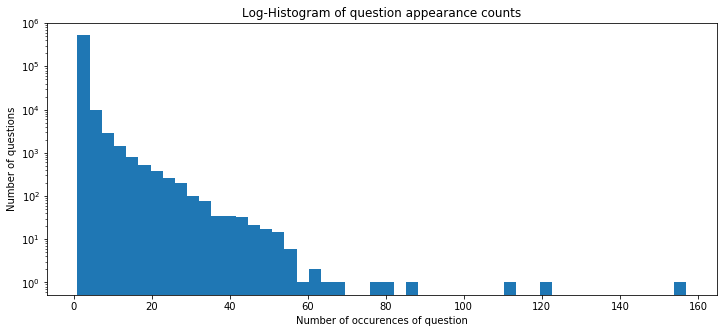

In [29]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

C:\Users\toti\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\toti\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Mean-train: 59.82 
Std-train: 31.96 
Mean-test: 60.07 
Std-test: 31.62 
Max-train: 1169.00 
Max-test: 1176.00


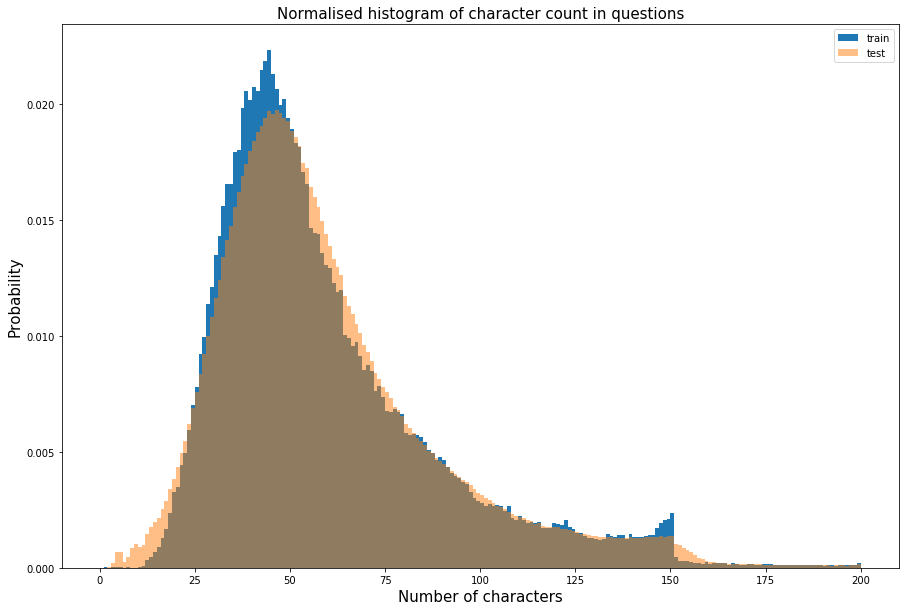

In [30]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], normed=True, alpha=0.5, label='test')

plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('Mean-train: {:.2f} \nStd-train: {:.2f} \nMean-test: {:.2f} \nStd-test: {:.2f} \nMax-train: {:.2f} \nMax-test: {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

# Preprocessing

In [121]:
def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"

    for i in range(len(mylist)):
        mylist[i]= str(mylist[i])

    return mylist

In [122]:
all_q1 = cast_list_as_strings(list_q1)
all_q2 = cast_list_as_strings(list_q2)

### CountVectorizer

In [123]:
import scipy
import scipy.sparse as sp
import numpy as np
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import defaultdict
import sklearn
import re
stemmer =  SnowballStemmer(language='english')


class SimpleCountVectorizer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    
    def __init__(self,
                 min_word_counts=1,
                 doc_cleaner_pattern=r"[^a-zA-Z]",
                 token_pattern=r"(?u)\b\w\w+\b",
                 dtype=np.float32,
                 doc_cleaner_func=None,
                 tokenizer_func=None,
                 word_transformer_func=None):
        
        self._retype = type(re.compile('hello, world'))

        self.min_word_counts     = min_word_counts
        self.doc_cleaner_pattern = doc_cleaner_pattern
        self.token_pattern       = token_pattern
        self.dtype               = dtype
        
        self.doc_cleaner_func      = doc_cleaner_func
        self.tokenizer_func        = tokenizer_func
        self.word_transformer_func = word_transformer_func

        self.vocabulary = set()
        self.word_to_ind = {}


    def build_doc_cleaner(self, lower=True):
        """
        Returns a function that cleans undesirable substrings in a string.
        It also lowers the input string if lower=True
        """
        if self.doc_cleaner_func:
            return self.doc_cleaner_func
        else:
            if isinstance(self.doc_cleaner_pattern, self._retype):
                #clean_doc_pattern = self.doc_cleaner_pattern.sub(" ", doc)
                clean_doc_pattern = re.compile(self.doc_cleaner_pattern)
            else:
                clean_doc_pattern = re.compile(self.doc_cleaner_pattern)

            if lower:
                 return lambda doc: clean_doc_pattern.sub(" ", doc).lower()
            else:
                 return lambda doc: clean_doc_pattern.sub(" ", doc)

    def build_tokenizer(self):
        """Returns a function that splits a string into a sequence of tokens"""
        if self.tokenizer_func:
            return self.tokenizer_func
        
        else:
            token_pattern = re.compile(self.token_pattern)
            return lambda doc: token_pattern.findall(doc)

    def build_word_transformer(self):
        """Returns a stemmer or lemmaitzer if object has any"""
        
        if self.word_transformer_func:
            return self.word_transformer_func
        else:
            return lambda word: word
        
    def tokenize(self, doc):
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        doc     = doc_cleaner(doc)
        words = doc_tokenizer(doc)
            
        return words
        
    def fit(self, X):

        assert self.vocabulary == set(), "self.vocabulary is not empty it has {} words".format(len(self.vocabulary))
        assert isinstance(X,list), "X is expected to be a list of documents"
        
        i = 0
        word_to_ind = {}
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        word_transformer = self.build_word_transformer()
        
        for x in X:
            words = doc_cleaner(x)
            words = doc_tokenizer(words)
            for word in words:
                if word not in word_to_ind:
                    word_to_ind[word] = i
                    i += 1
        self.word_to_ind = word_to_ind
        self.n_features = len(word_to_ind)    
                
        self.vocabulary = set(word_to_ind.keys())
                
        return self
    
    def transform(self, X, memory_efficient=False):
        
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        word_transformer = self.build_word_transformer()      
        
        col_indices = []
        row_indices = []
        sp_data     = []
                
        if memory_efficient:
            for m, x in enumerate(X):  
                words = doc_cleaner(x)
                words = doc_tokenizer(words)
                for word in words: 
                    index = self.word_to_ind[word]
                    
                    col_indices.append(index)
                    row_indices.append(m)
                    sp_data.append(1)
                    
            encoded_X = sp.csr_matrix((sp_data, (row_indices, col_indices)), shape = (len(X) ,self.n_features)) 
                        
        else:
            
            encoded_X = np.zeros((len(X), len(self.word_to_ind)))
            for m, x in enumerate(X):  
                words = doc_cleaner(x)
                words = doc_tokenizer(words)
                for word in words: 
                    index = self.word_to_ind[word]
                    encoded_X[m, index] += 1
        
        return encoded_X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        encoded_X = self.transform(X)
        return encoded_X
    
    def _words_in_vocab(self, X):
        
        if isinstance(X, str):
            return [w for w in self.tokenize(X) if w in self.vocabulary]
        
        X_words_in_vocab = []
        for sentence in X:
            X_words_in_vocab.append(self.tokenize(sentence))
            
        return X_words_in_vocab

### Lower case

In [124]:
# LOWER ALL THE CASES IN THE DATAFRAME
df_train['question1'] = df_train['question1'].str.lower()
df_train['question2'] = df_train['question2'].str.lower()

# # MAYBE ITS IMPORTANT TO KEEP THE FIRST LETTER IN STRING AS UPPER TO INDICATE BEGGINING OF THE STRING?
# df_train['question1'] = df_train['question1'].str.capitalize() 
# df_train['question2'] = df_train['question2'].str.capitalize() 

df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0


In [125]:
list_q1 = list(df_train["question1"])
list_q2 = list(df_train["question2"])

### Lematitzation and word tokenize

In [143]:
lemmatizer = WordNetLemmatizer()

def list_lematization(lists):
    output=[]
    for sentence in lists:
        # Tokenize: Split the sentence into words
        word_list = nltk.word_tokenize(sentence)

        # Lemmatize list of words and join
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        output.append(lemmatized_output)
    return output
        
list_q1_lematized = list_lematization(list_q2[0:10])
list_q1_lematized

['what is the step by step guide to invest in share market ?',
 'what would happen if the indian government stole the kohinoor ( koh-i-noor ) diamond back ?',
 'how can internet speed be increased by hacking through dns ?',
 'find the remainder when [ math ] 23^ { 24 } [ /math ] is divided by 24,23 ?',
 'which fish would survive in salt water ?',
 "i 'm a triple capricorn ( sun , moon and ascendant in capricorn ) what doe this say about me ?",
 'what keep childern active and far from phone and video game ?',
 'what should i do to be a great geologist ?',
 "when do you use `` & '' instead of `` and '' ?",
 'how do i hack motorola dcx3400 for free internet ?']

### Num2Words

In [145]:
num2words('1035110')

'one million, thirty-five thousand, one hundred and ten'

### Stop Words

In [146]:
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 
              'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 
              'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 
              's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
              'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 
              'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 
              'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 
              'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 
              'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 
              'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 
              'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 
              'it', 'how', 'further', 'was', 'here', 'than']

  
# df_train['question1'].apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
### WHAT ELSE?